## Visualisations of Evolutionary Algorithms
---
Producing plots for the master thesis.

In [6]:
# loading packages
import pathlib
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.decomposition.asf import ASF

# defining the multiobjective problem for square FEA problem: Weight/vm_stress obj
class MyProblem(ElementwiseProblem):

    def __init__(self, conn, coords, num_el, meshpath):
        super().__init__(n_var=num_el,
                         n_obj=2,
                         n_ieq_constr=0,
                         xl=np.zeros(num_el),
                         xu=np.ones(num_el)
                         )
        self.conn = conn
        self.coords = coords
        self.num_el = num_el
        self.meshpath = meshpath  # temp mesh for evaluation

    def _evaluate(self, x, out, *args, **kwargs):

        # generate the infill file
        generate_infill_file(self.meshpath, x, self.conn, self.coords)

        # Loading the created infill mesh to FEniCS
        mesh, _, _, _ = extract_mesh_data_fenics(meshfile)

        # perform FEA and obtain displacements and von mises stress
        d_max, d_tot, d_avg, max_vm = dogbone_FEA(mesh)

        # objective values: we want to minimize *weight* and *maximal stress*
        f1 = np.sum(x)  # objective 1 - "weight"
        f2 = max_vm     # objective 2 - "maxStress"

        # constraints
        #g1 = np.sum(x) - 200   # dummy constraint: can be adjusted to limit the infill rate

        out["F"] = [f1, f2]  # dictionary key for objectives
        #out["G"] = [g1]      # dictionary key for constraints

Generation: 1 	Chosen solutions: [4]
		Objective values [[61.      0.0255]]


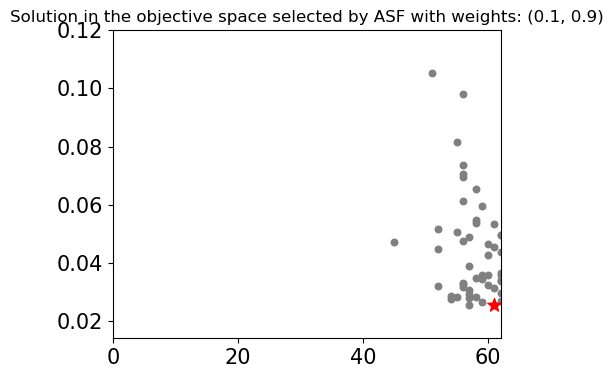

Generation: 1 	Chosen solutions: [4, 5]
		Objective values [[61.      0.0255]
 [52.      0.032 ]]


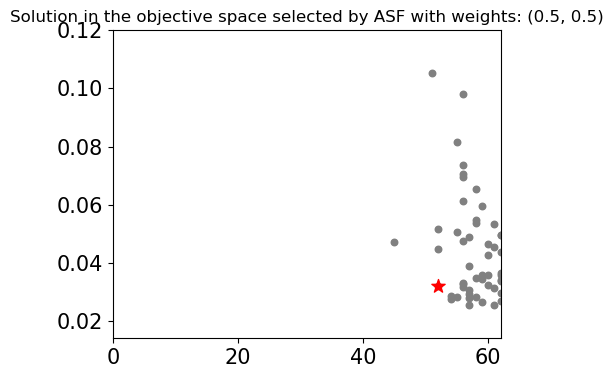

Generation: 1 	Chosen solutions: [4, 5, 1]
		Objective values [[61.      0.0255]
 [52.      0.032 ]
 [45.      0.047 ]]


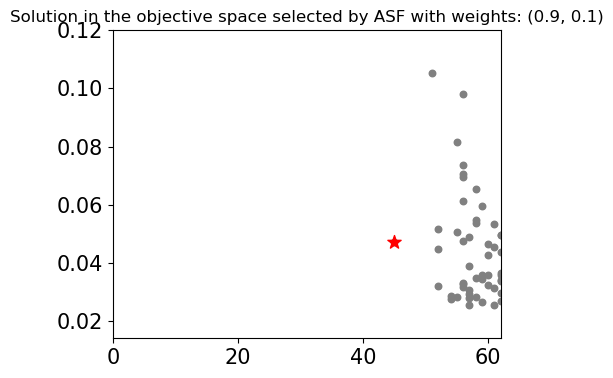

Generation: 50 	Chosen solutions: [13]
		Objective values [[37.      0.0215]]


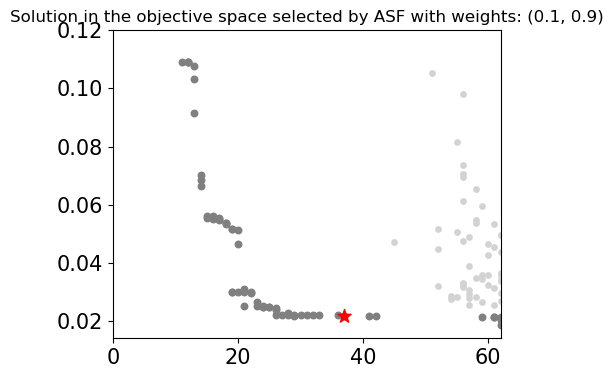

Generation: 50 	Chosen solutions: [13, 12]
		Objective values [[37.      0.0215]
 [21.      0.0249]]


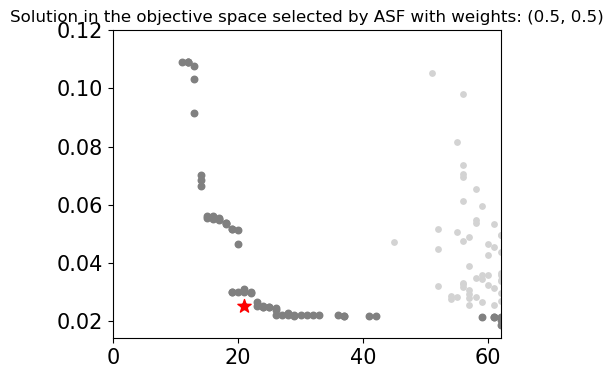

Generation: 50 	Chosen solutions: [13, 12, 29]
		Objective values [[37.      0.0215]
 [21.      0.0249]
 [15.      0.0555]]


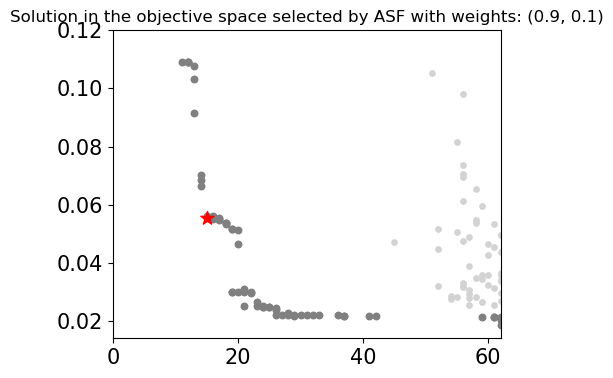

Generation: 100 	Chosen solutions: [32]
		Objective values [[61.      0.0182]]


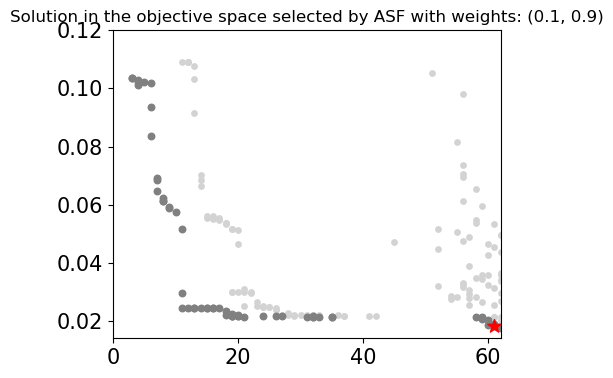

Generation: 100 	Chosen solutions: [32, 17]
		Objective values [[61.      0.0182]
 [15.      0.0243]]


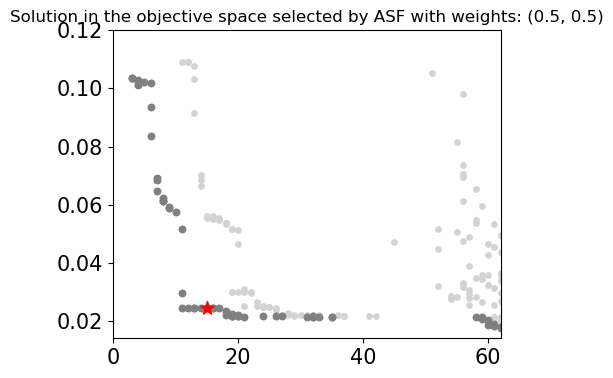

Generation: 100 	Chosen solutions: [32, 17, 9]
		Objective values [[61.      0.0182]
 [15.      0.0243]
 [ 8.      0.0613]]


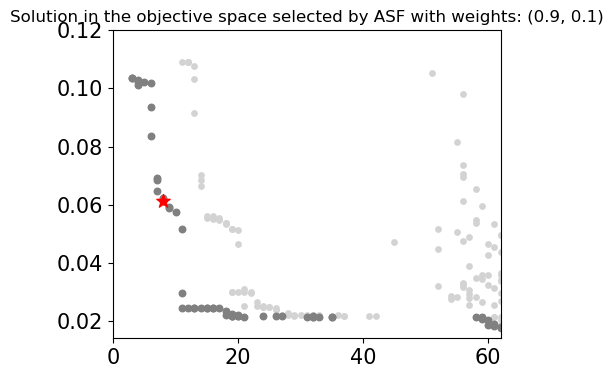

Generation: 150 	Chosen solutions: [40]
		Objective values [[58.      0.0182]]


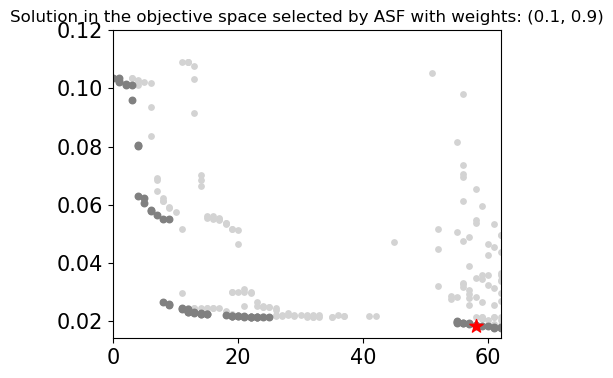

Generation: 150 	Chosen solutions: [40, 8]
		Objective values [[58.      0.0182]
 [12.      0.023 ]]


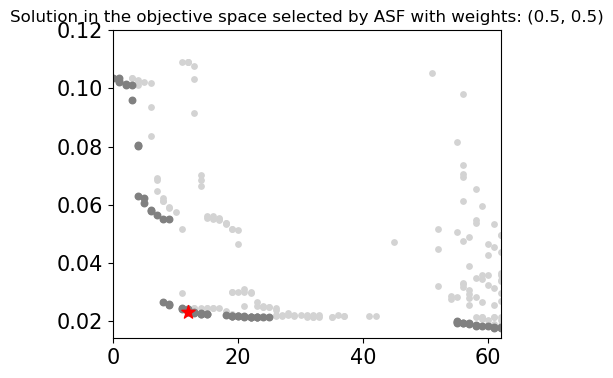

Generation: 150 	Chosen solutions: [40, 8, 34]
		Objective values [[58.      0.0182]
 [12.      0.023 ]
 [ 5.      0.0605]]


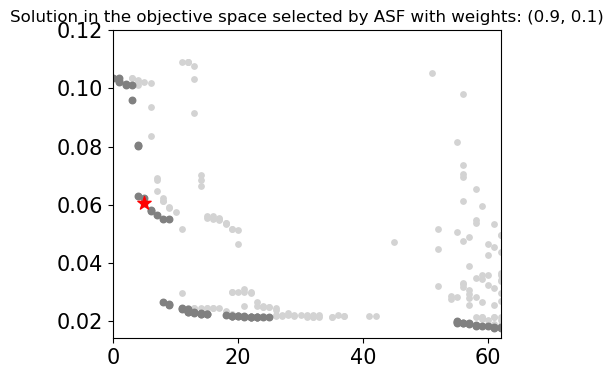

Generation: 200 	Chosen solutions: [48]
		Objective values [[58.      0.0178]]


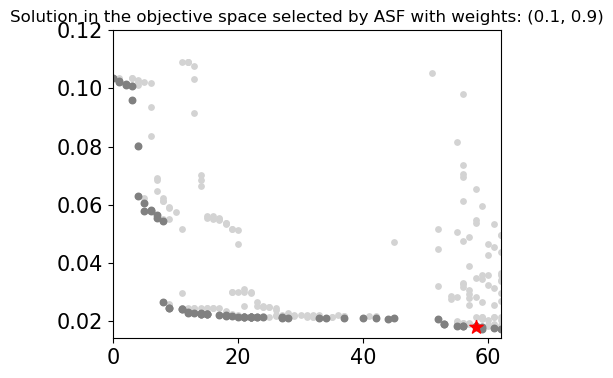

Generation: 200 	Chosen solutions: [48, 19]
		Objective values [[58.      0.0178]
 [12.      0.0228]]


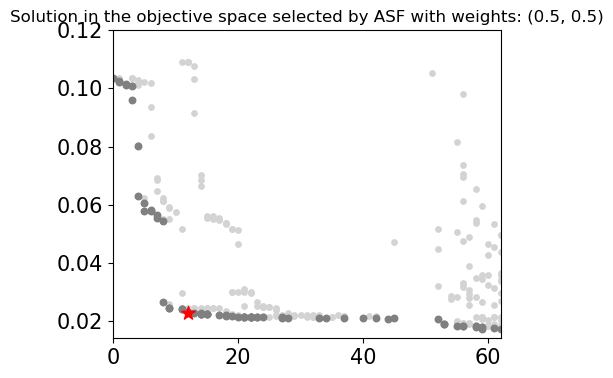

Generation: 200 	Chosen solutions: [48, 19, 47]
		Objective values [[58.      0.0178]
 [12.      0.0228]
 [ 5.      0.0579]]


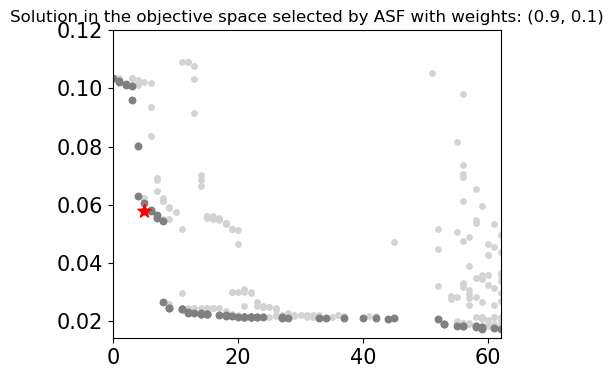

Generation: 250 	Chosen solutions: [39]
		Objective values [[58.      0.0173]]


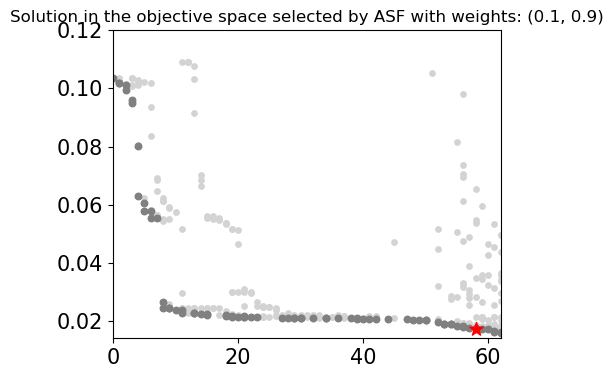

Generation: 250 	Chosen solutions: [39, 20]
		Objective values [[58.      0.0173]
 [11.      0.0227]]


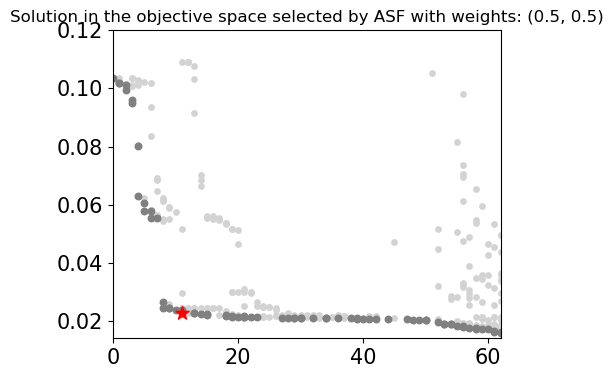

Generation: 250 	Chosen solutions: [39, 20, 12]
		Objective values [[58.      0.0173]
 [11.      0.0227]
 [ 5.      0.0579]]


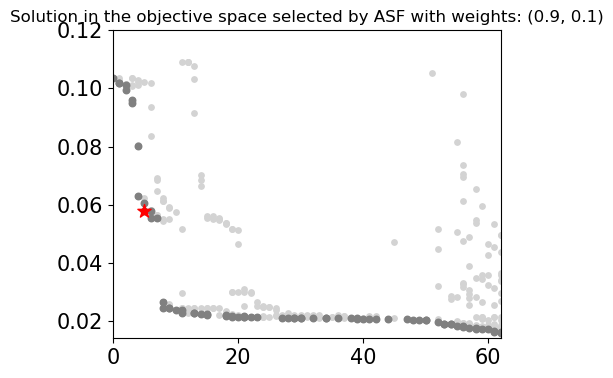

Generation: 300 	Chosen solutions: [32]
		Objective values [[60.     0.017]]


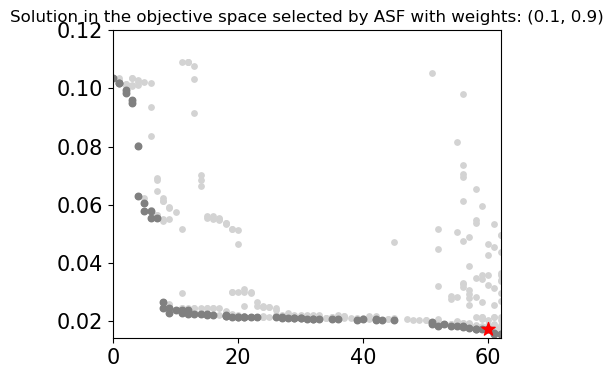

Generation: 300 	Chosen solutions: [32, 7]
		Objective values [[60.      0.017 ]
 [11.      0.0227]]


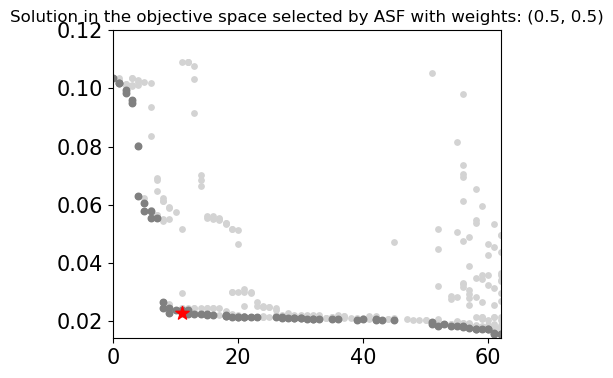

Generation: 300 	Chosen solutions: [32, 7, 3]
		Objective values [[60.      0.017 ]
 [11.      0.0227]
 [ 5.      0.0579]]


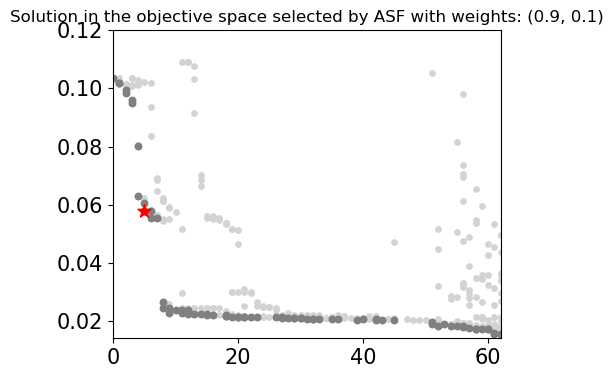

In [122]:
# plot one: history

# Filepath management
cwd = Path.cwd()
mesh_dir = cwd.joinpath("MOEA_meshes", "dogbones")  # adjust the dir here
inf_file = 'dogbone_type1-infill-small.msh'
mesh_inp = mesh_dir / inf_file  # mesh input file
out_dir = mesh_dir / "infill_gen0-300g"
plot_dir = out_dir / "plots"
plot_dir.mkdir(exist_ok=True)

# load the history from a pickle file
with open(out_dir /'history.pkl', 'rb') as f:
    load_hist = pickle.load(f)

select = [0, 49, 99, 149, 199, 249, 299]
selected_hist = [load_hist[i] for i in select]
np.set_printoptions(precision=4, suppress=True)

# print(load_hist[-1].pop[1].X * 1)
# print(load_hist[-1].pop[1].F)
CF = []
for i, ihist in enumerate(selected_hist):
    pop = ihist.pop  # population at a particular generation
    gen = select[i]  # generation number

    F = pop.get('F')  # get the objective values
    X = pop.get('X')  # get the decision variables
    CF.append(F)      # cumulative objective values


    # normalizing F with respect to both objectives
    approx_ideal = F.min(axis=0)  # ideal point
    approx_nadir = F.max(axis=0)  # nadir point
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)  # normalized objectives

    # Decision making: Using Augmented Scalarization Function (ASF)
    decomp = ASF()                  # init the ASF metric to be minimized
    weights = np.array([[0.1, 0.9], [0.5,0.5], [0.9, 0.1]])  # weighting the objectives
    best_ASF = []  # indexes of chosen solutions
    for k, weight in enumerate(weights):
        best_ASF.append(decomp.do(nF, 1/weight).argmin())  # index of the best solution regarding ASF
        F_ASF = F[best_ASF, :]   # objectives
        X_ASF = X[best_ASF, :]   # solutions
        print(f"Generation: {gen+1} \tChosen solutions: {best_ASF}")###
        print(f"\t\tObjective values {F_ASF}")


        # plotting the objective space
        fig, ax = plt.subplots(figsize=(5, 4))
        for f in CF[:-1]:
            plt.scatter(f[:, 0], f[:, 1], s=15, marker='o',
                    facecolors='lightgray', edgecolors='lightgray')  # previous objective space
        plt.scatter(F[:, 0], F[:, 1], s=22, marker='o',
                    facecolors='gray', edgecolors='gray')            # current objective space
        plt.scatter(F_ASF[k, 0], F_ASF[k, 1], s=100, marker='*',
                    facecolors='red', edgecolors='red')              # selected point

        ax.set_xlim((0, 62))
        ax.set_ylim((0.014, 0.12))
        ax.tick_params(axis="x", labelsize=15)
        ax.tick_params(axis="y", labelsize=15)


        plt.savefig(plot_dir / f"w{int(weight[0]*10):01d}-{int(weight[1]*10):01d}_gen{gen+1:03d}.png")
        plt.title(f"Solution in the objective space selected by ASF with weights: ({weight[0]}, {weight[1]})")
        plt.show()
        plt.cla()
        plt.clf()
        plt.close()
